In [265]:
import pandas
import cv2
import networkx
from matplotlib import pyplot
from Bio import SeqIO, AlignIO, pairwise2

In [281]:
data_dir = "../../data"
big_one = "chlorocebus_sabaeus_ENSCSAG00000011845"
small_one = "mandrillus_leucophaeus_ENSMLEG00000035424"
dataset = "orthologs_neuroglobin"
types = "N"

In [313]:
def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def plot(title, img):
    fig, ax = pyplot.subplots(1, 1, figsize=(5, 10), layout="constrained")
    ax.set_title(title)
    ax.imshow(img)

def draw_on_image(img, x1, y1, x2=None, y2=None, color=(255,255,255)):
    x2 = x2 or x1+1
    y2 = y2 or y1+1
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)

def get_small_and_big(data_dir, types, dataset, small_one, big_one):
    img_small = load_img(f"{data_dir}/images/{types}/{dataset}/full/{small_one}.png")
    img_big = load_img(f"{data_dir}/images/{types}/{dataset}/full/{big_one}.png")
    return img_small, img_big

def align_to_image(seq_with_gaps):
    idx_align = []
    for k, l in enumerate(seq_with_gaps):
        if l != "-":
            idx_align.append(k)
    return idx_align

def plot_control(data_dir, types, dataset, small_one, big_one, control_small, control_big, name):
    img_small, img_big = get_small_and_big(data_dir, types, dataset, small_one, big_one)
    for i in control_small:
        draw_on_image(img_small, i, i)
    plot(f"{name} Control with {small_one}", img_small)
    for i in control_big:
        draw_on_image(img_big, i, i)
    plot(f"{name} Control with {big_one}", img_big)

def plot_pairwise_control(data_dir, types, dataset, small_one, big_one, paiwise_func, name):
    seqs = SeqIO.parse(f"{data_dir}/{dataset}.fasta.{types}.sanitized", "fasta")
    to_align = []
    for s in seqs:
        if s.description == big_one:
            big_img = (s.description, s.seq)
            to_align.append(big_img)
        elif s.description == small_one:
            small_img = (s.description, s.seq)
            to_align.append(small_img)
    ali = paiwise_func(*[s for n, s in to_align])[0]
    big_ali, small_ali = (ali.seqB, ali.seqA) if ali.seqA.replace("-", "") == big_img[1] else (ali.seqA, ali.seqB)
    control_big = align_to_image(big_ali)
    control_small = align_to_image(small_ali)
    plot_control(data_dir, types, dataset, small_one, big_one, control_small, control_big, name)

def plot_clustal(data_dir, types, dataset, small_one, big_one):
    align = AlignIO.read(f"{data_dir}/trees/{types}/full/{dataset}/Control with Clustal Omega.fasta", "fasta")
    for a in align:
        if a.description == big_one:
            big_str_clustal = str(a.seq)
        if a.description == small_one:
            small_str_clustal = str(a.seq)
    control_big = align_to_image(big_str_clustal)
    control_small = align_to_image(small_str_clustal)
    plot_control(data_dir, types, dataset, small_one, big_one, control_small, control_big, "Clustal")

    
def draw_control(data_dir, types, dataset, small_one, big_one):
    plot_pairwise_control(data_dir, types, dataset, small_one, big_one, pairwise2.align.globalxx, "Global")
    plot_pairwise_control(data_dir, types, dataset, small_one, big_one, pairwise2.align.localxx, "Local")
    plot_clustal(data_dir, types, dataset, small_one, big_one)

def filter_images_data(df, small_one, big_one):
    df_filter_test = df[(df.img1 == f"{big_one}.png") & (df.img2 == f"{small_one}.png")]
    return df_filter_test.reset_index(drop=True).reset_index(drop=True)    

def draw_ground_truth(img_big):
    draw_on_image(img_big, 100, 100, 452, 452, (255, 215, 0))

def draw_windowed(data_dir, types, dataset, small_one, big_one):
    algorithm = "Windowed MultiScale Structural Similarity Index Measure"
    df = pandas.read_csv(f"{data_dir}/trees/{types}/full/{dataset}/{algorithm}.map")
    df_filter_test = filter_images_data(df, small_one, big_one)
    dict_filter_test = df_filter_test[df_filter_test["score"] == df_filter_test.score.max()].reset_index().to_dict("records")
    img_small, img_big = get_small_and_big(data_dir, types, dataset, small_one, big_one)
    plot(f"{algorithm} with {small_one}", img_small)
    for i in dict_filter_test:
        draw_on_image(img_big, i["start_col"], i["start_col"], i["stop_col"]-2, i["stop_col"]-2)
    draw_ground_truth(img_big)
    plot(f"{algorithm} with {big_one}", img_big)

def draw_greedy(data_dir, types, dataset, small_one, big_one):
    algorithm = "Greedy Sliced Structural Similarity Index Measure"
    df = pandas.read_csv(f"{data_dir}/trees/{types}/full/{dataset}/{algorithm}.map")
    df_filter_test = filter_images_data(df, small_one, big_one)
    dict_filter_test = df_filter_test.to_dict("records")
    img_small, img_big = get_small_and_big(data_dir, types, dataset, small_one, big_one)
    plot(f"{algorithm} with {small_one}", img_small)
    for i in dict_filter_test:
        draw_on_image(img_big, i["start_col"], i["start_line"], i["stop_col"]-2, i["stop_line"]-2)
    draw_ground_truth(img_big)
    plot(f"{algorithm} with {big_one}", img_big)
    
def draw_unrestricted(data_dir, types, dataset, small_one, big_one):
    algorithm = "Unrestricted Sliced Structural Similarity Index Measure"
    df = pandas.read_csv(f"{data_dir}/trees/{types}/full/{dataset}/{algorithm}.map")
    df_filter_test = filter_images_data(df, small_one, big_one)
    df_filter_test["min_start_col"] = df_filter_test.stop_col - df_filter_test.stop_col.min()
    df_filter_test["min_col_score"] = df_filter_test.start_col - df_filter_test.min_start_col
    dict_filter_test = df_filter_test.groupby("min_col_score").max().reset_index().to_dict("records")
    img_small, img_big = get_small_and_big(data_dir, types, dataset, small_one, big_one)
    for i in dict_filter_test:
        draw_on_image(img_small, i["min_col_score"], i["min_col_score"])
    plot(f"{algorithm} with {small_one}", img_small)
    for i in dict_filter_test:
        draw_on_image(img_big, i["start_col"], i["start_col"])
    draw_ground_truth(img_big)
    plot(f"{algorithm} with {big_one}", img_big)


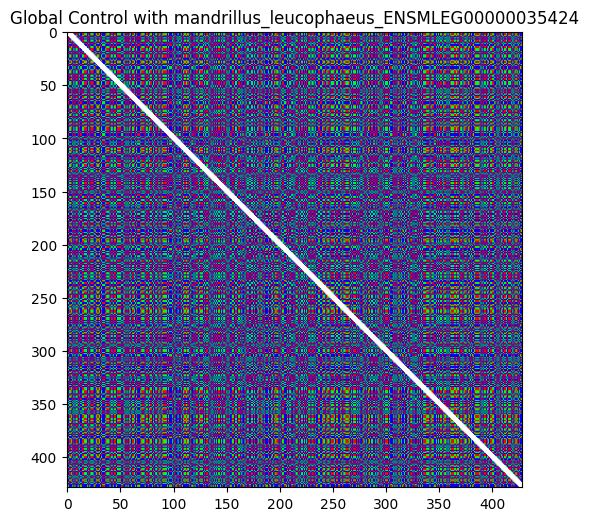

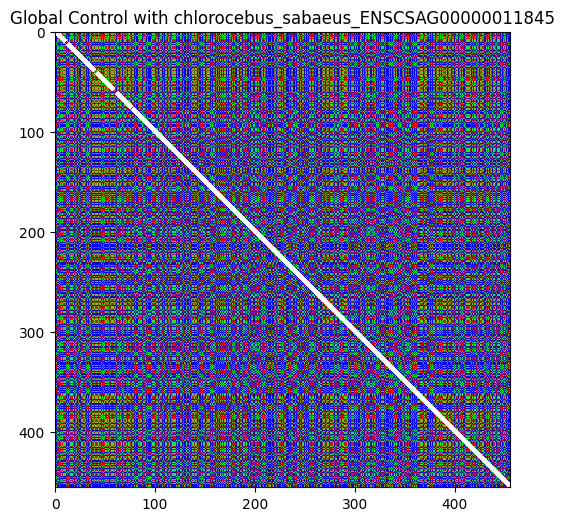

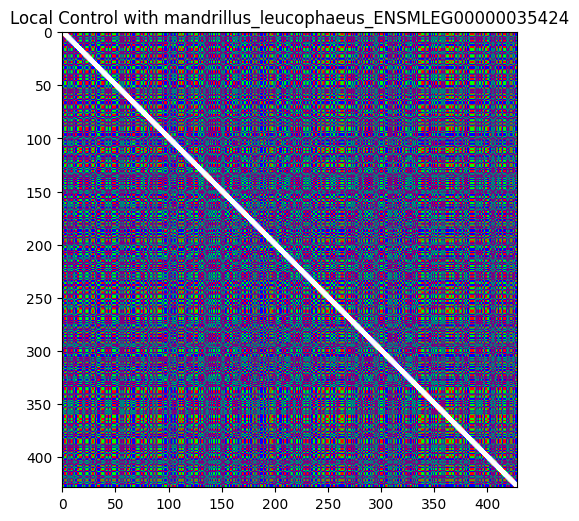

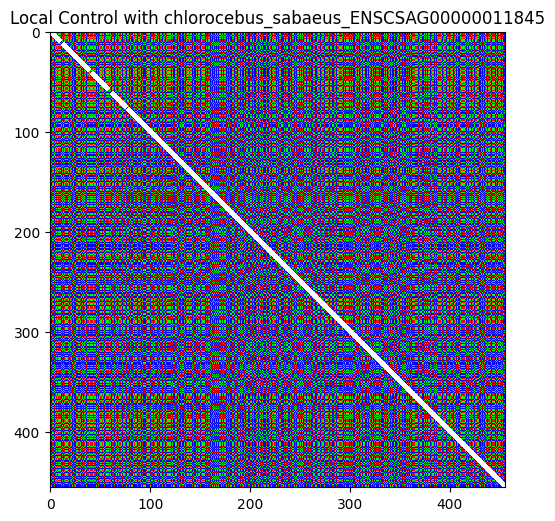

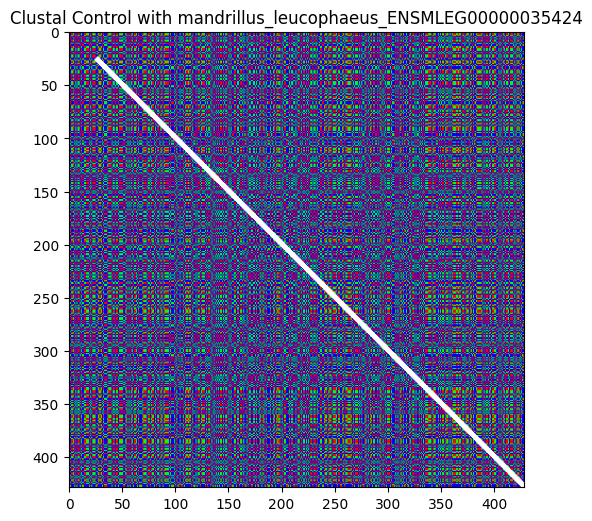

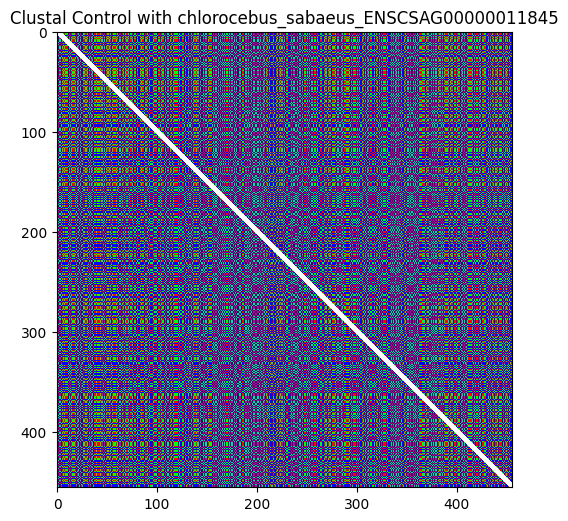

In [314]:
draw_control(data_dir, types, dataset, small_one, big_one)

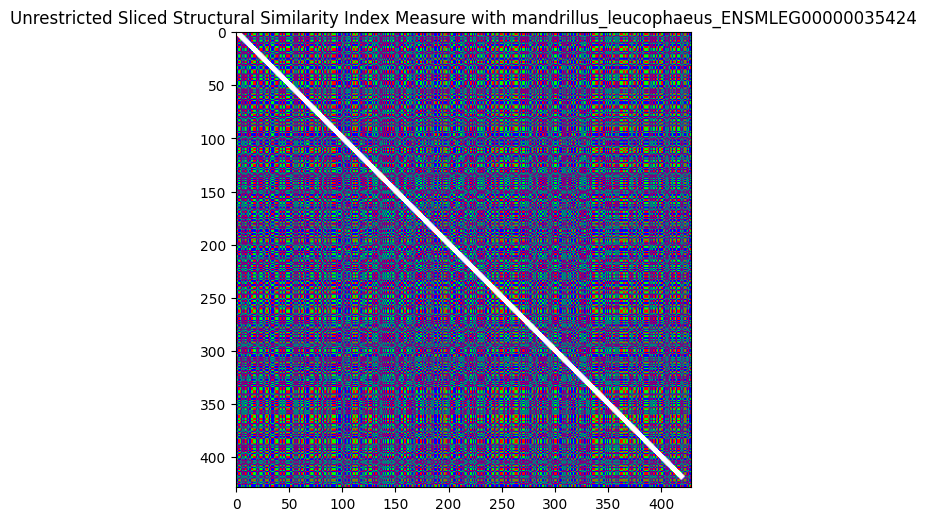

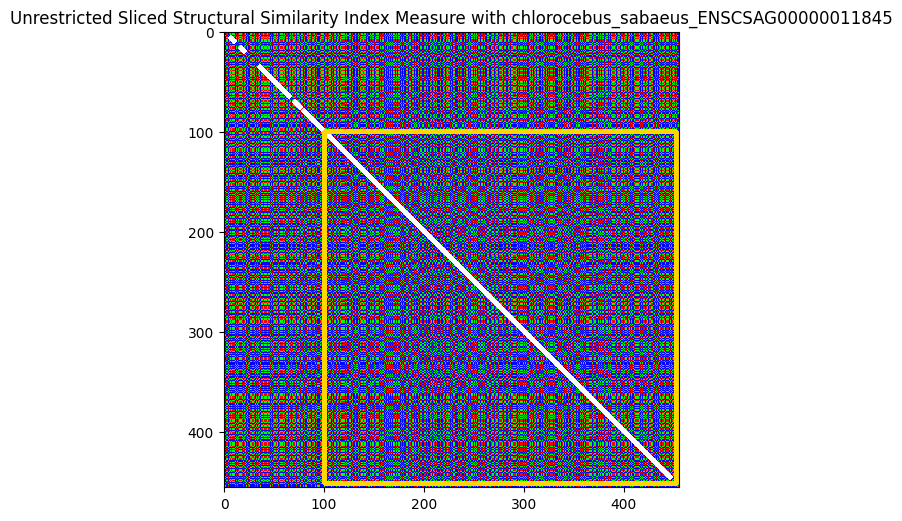

In [315]:
draw_unrestricted(data_dir, types, dataset, small_one, big_one)

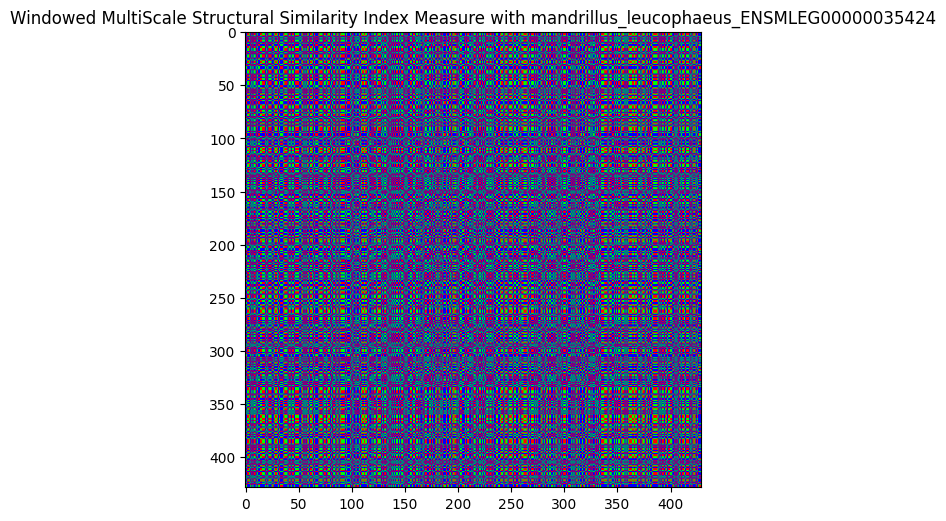

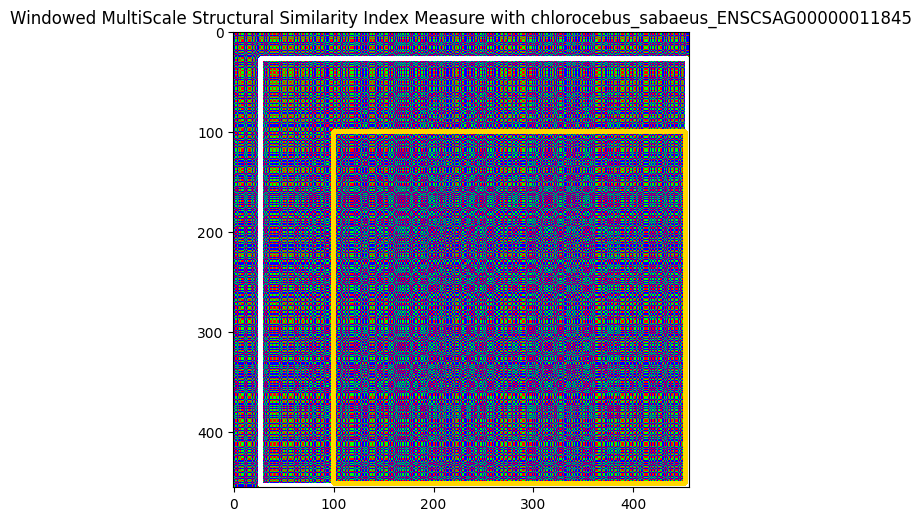

In [316]:
draw_windowed(data_dir, types, dataset, small_one, big_one)

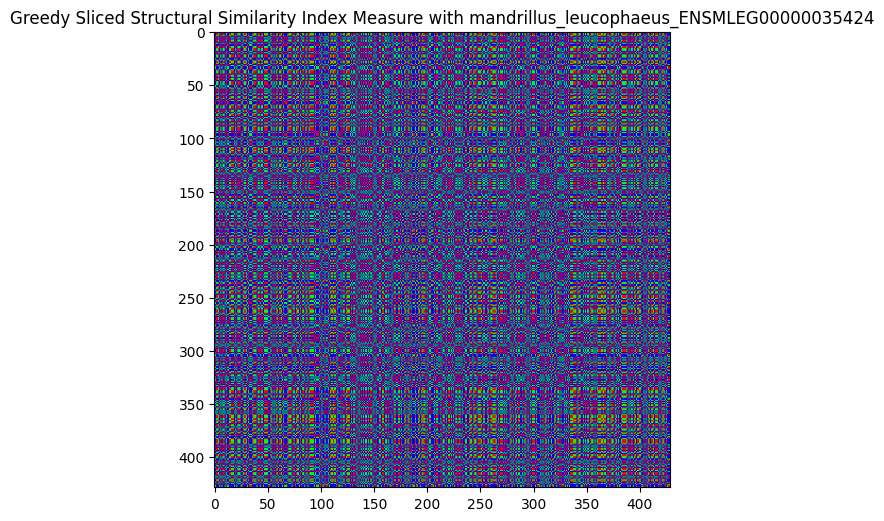

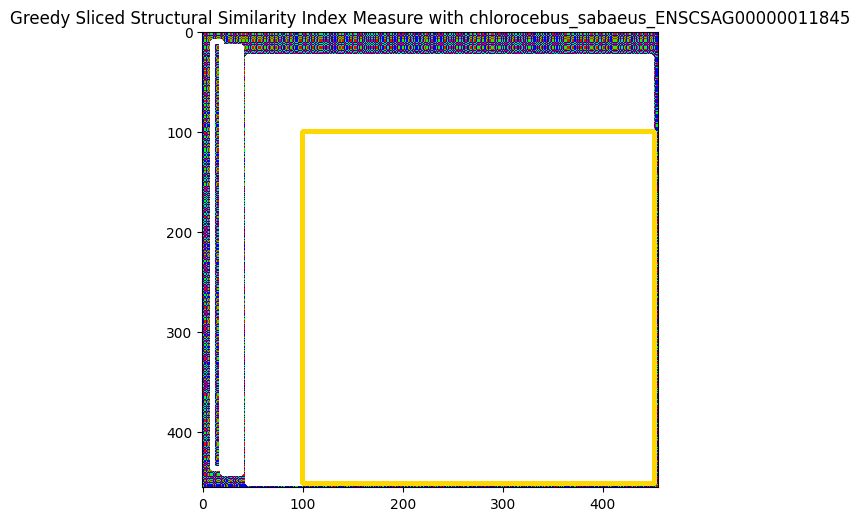

In [317]:
draw_greedy(data_dir, types, dataset, small_one, big_one)